In [1]:
!pip install transformers datasets torch pandas scikit-learn

In [2]:
# Required Libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load Dataset
data = pd.read_csv("/kaggle/input/new-datasets-final/final_datasets_new.csv")

In [4]:
# Combine textual features
def combine_features(row):
    return f"Text: {row['text']} | Objects: {row['detected_objects']} | Emotion: {row['Dominant Emotion']} | " \
           f"Race: {row['Dominant Race']} | Gender: {row['gender']} | Age Group: {row['age_group']} | " \
           f"Sentiment: {row['sentiment_analysis']}"

data['combined_features'] = data.apply(combine_features, axis=1)

# Prepare labels
data['label'] = data['label'].astype(int)

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['combined_features'].tolist(), 
    data['label'].tolist(), 
    test_size=0.2, 
    random_state=42
)

In [5]:
# Load Tokenizer and Model
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.config.pad_token_id = tokenizer.pad_token_id

# Convert to Dataset
train_data = Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_data = Dataset.from_dict({'text': val_texts, 'label': val_labels})

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen2.5-0.5B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Tokenization
def tokenize_data(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

train_data = train_data.map(tokenize_data, batched=True)
val_data = val_data.map(tokenize_data, batched=True)

train_data = train_data.remove_columns(['text'])
val_data = val_data.remove_columns(['text'])
train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/6800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1700 [00:00<?, ? examples/s]

In [7]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./qwen_results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=5e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./qwen_logs',
    logging_strategy="steps",
    logging_steps=50,
    save_total_limit=2,
    load_best_model_at_end=True,
    fp16=True,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [8]:
# Metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average="binary")
    acc = accuracy_score(p.label_ids, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.687600,0.609110,0.668824,0.583272,0.552595,0.617555
2,0.624100,0.670271,0.643529,0.590541,0.519002,0.684953
3,0.551100,0.647656,0.690000,0.382181,0.758140,0.255486
4,0.441700,0.776554,0.652941,0.571843,0.532432,0.617555
5,0.288200,0.886505,0.656471,0.524430,0.545763,0.504702


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

TrainOutput(global_step=1065, training_loss=0.5386079573295486, metrics={'train_runtime': 2592.6776, 'train_samples_per_second': 13.114, 'train_steps_per_second': 0.411, 'total_flos': 9345482293248000.0, 'train_loss': 0.5386079573295486, 'epoch': 5.0})

In [9]:
# Evaluate
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Evaluation Results: {'eval_loss': 0.6091101765632629, 'eval_accuracy': 0.6688235294117647, 'eval_f1': 0.5832716506291636, 'eval_precision': 0.5525946704067322, 'eval_recall': 0.6175548589341693, 'eval_runtime': 42.2518, 'eval_samples_per_second': 40.235, 'eval_steps_per_second': 1.278, 'epoch': 5.0}


In [10]:
# Save model and tokenizer
model.save_pretrained('./qwen_hate_classification')
tokenizer.save_pretrained('./qwen_hate_classification')

('./qwen_hate_classification/tokenizer_config.json',
 './qwen_hate_classification/special_tokens_map.json',
 './qwen_hate_classification/vocab.json',
 './qwen_hate_classification/merges.txt',
 './qwen_hate_classification/added_tokens.json',
 './qwen_hate_classification/tokenizer.json')

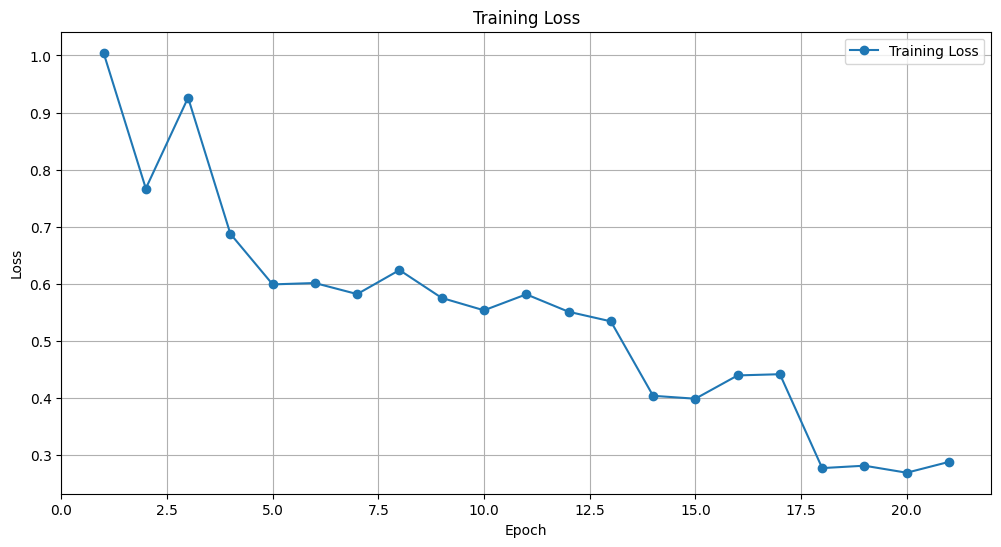

In [15]:
import matplotlib.pyplot as plt

# Extract training and evaluation losses
training_logs = trainer.state.log_history

# Extract training loss values
train_loss = [log['loss'] for log in training_logs if 'loss' in log]
eval_loss =  [log["eval_loss"] for log in training_logs if "eval_loss" in log]

# Ensure eval_loss has the same length as train_loss by filling missing values with None
# If eval_loss is shorter, append None for missing steps to match the train_loss length
eval_loss_extended = eval_loss + [None] * (len(train_loss) - len(eval_loss))

# Create a list of epochs corresponding to the length of train_loss
epochs = list(range(1, len(train_loss) + 1))

# If eval_loss_extended is shorter than epochs, truncate it
if len(eval_loss_extended) > len(epochs):
    eval_loss_extended = eval_loss_extended[:len(epochs)]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label="Training Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)
plt.show()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


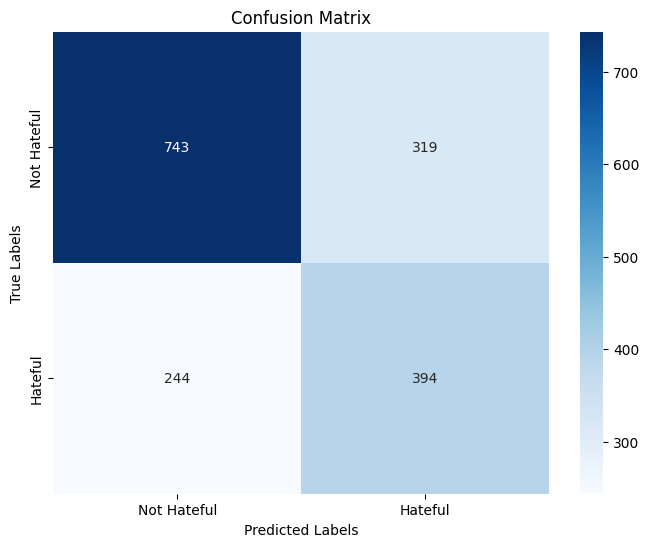

In [12]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
import seaborn as sns


# Predictions for Confusion Matrix
predictions = trainer.predict(val_data)
y_preds = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Hateful", "Hateful"], yticklabels=["Not Hateful", "Hateful"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()